In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [10]:
import matplotlib as mlp

plt.style.use('dark_background')

mlp.rcParams['lines.linewidth'] = 2

mlp.rcParams['xtick.major.size'] = 15
mlp.rcParams['xtick.major.width'] = 2
mlp.rcParams['xtick.labelsize'] = 15
mlp.rcParams['xtick.color'] = '#4DFC2D'

mlp.rcParams['ytick.major.size'] = 15
mlp.rcParams['ytick.major.width'] = 2
mlp.rcParams['ytick.labelsize'] = 15
mlp.rcParams['ytick.color'] = '#4DFC2D'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#ED6919'
mlp.rcParams['axes.labelcolor'] = '#ED6919'

In [59]:
df = pd.read_csv('data.csv')

df.head()

,Дней стельности при событии,Дни доения при событии,protokol,struck,result,stage
0,291,213,МВ,0.00,0.50,0
1,291,215,ТМ6,0.50,0.75,1
2,291,221,КМ4,0.75,0.00,2
3,0,294,КМ5,0.25,0.00,0
4,0,302,КМ4,0.25,0.25,1


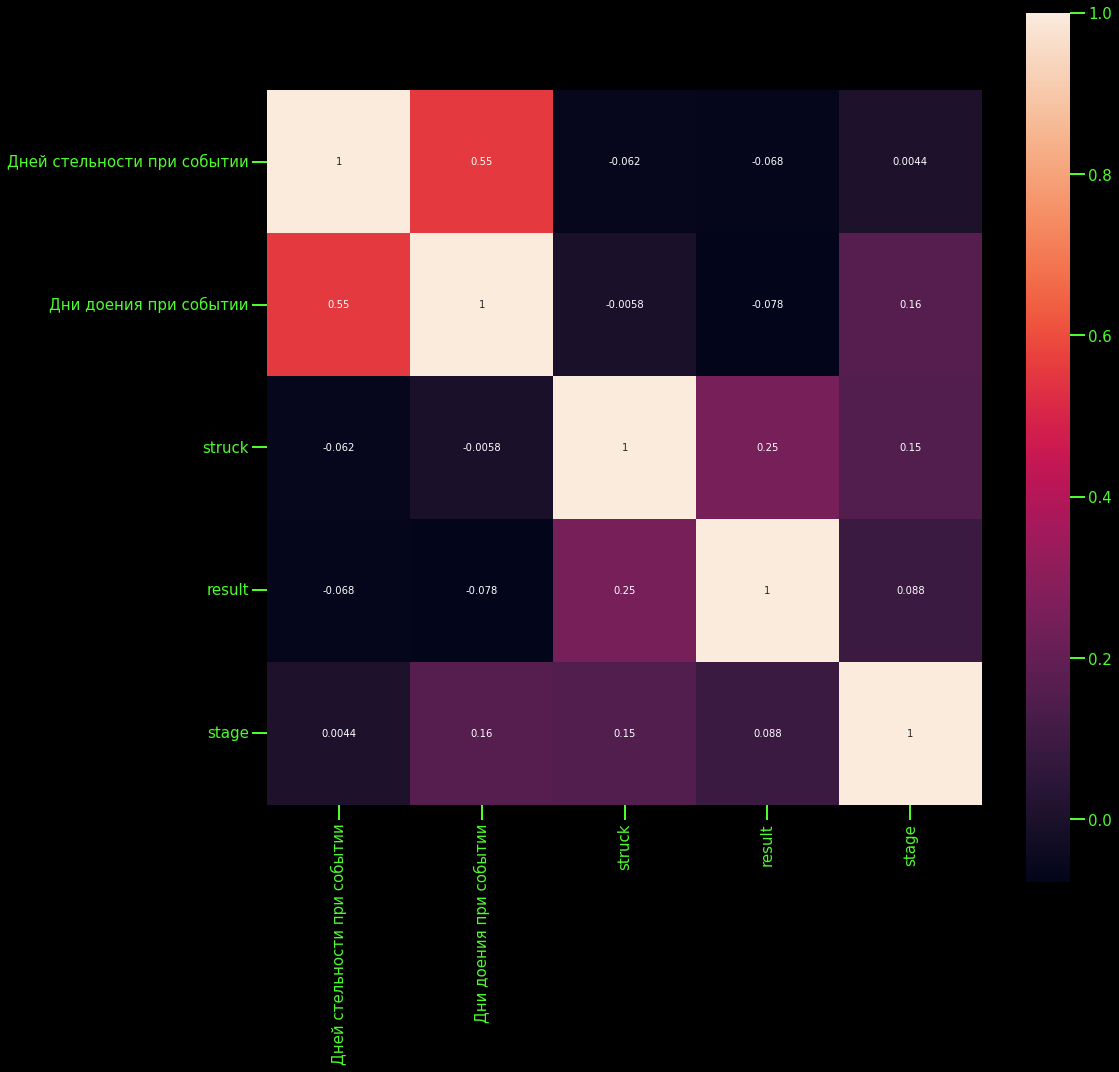

In [60]:
plt.figure(figsize=(16, 16))

sns.heatmap(df.corr('spearman'), square=True, annot=True)

plt.show()

*Номер лактации* и *Возраст* очень сильно скоррелированы => можем дропнуть одну из этих колонок


Кажется, что лучше будет оставить номер лактации (можно закодировать как категориальную колонку и модель не так сильно будет переобучаться)

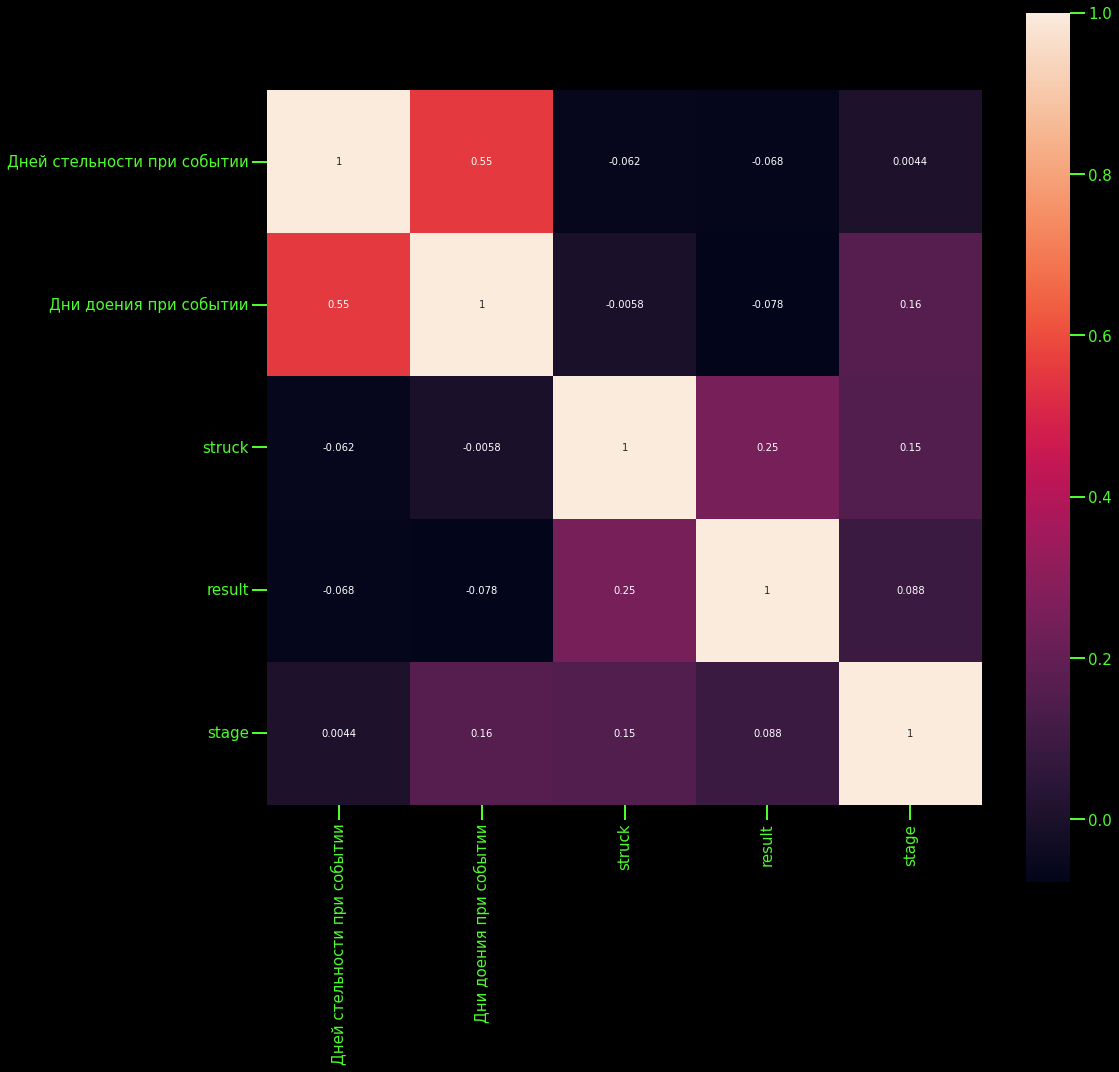

In [61]:
plt.figure(figsize=(16, 16))

sns.heatmap(df.corr('spearman'), square=True, annot=True)

plt.show()

Теперь с корреляциями все ок

Порог дисперсии не проходят только категориальная колонка `protokol`, `struck`  и таргетная переменная `result`

Категориальную колонку протокола мы даже не скармливали VarianceThreshold, `struck` имеет низкий разброс из-за своего масштаба, а таргет трогать не будем => все колонки хорошие по этому признаку

In [62]:
df.head()

,Дней стельности при событии,Дни доения при событии,protokol,struck,result,stage
0,291,213,МВ,0.00,0.50,0
1,291,215,ТМ6,0.50,0.75,1
2,291,221,КМ4,0.75,0.00,2
3,0,294,КМ5,0.25,0.00,0
4,0,302,КМ4,0.25,0.25,1


Также кажется, что можно убрать колонки $ \{p_i\}_{i=1}^4 $ - доли вымени, скорее всего, симметричны, и здесь нас интересует только соотношение пораженных ко всем

In [63]:
df.result.value_counts()

0.00    4484
0.25    2549
0.50     859
1.00     263
0.75     213
Name: result, dtype: int64

Видно, что даже без применения поправок при множественном сравнении, мы не можем быть отвергнуть нулевую гипотезу о том, что хотя бы для одной из пар различных значений результата значение признака `Дней в сухостое предыдущей лактации` будет различаться


Получается, стоит удалить и эту колонку

Попробуем автоматизировать множественную проверку гипотез для каждой из численных фичей

Здесь уже будем применять поправку Холма-Бонферонни, чтобы уменьшить вероятность детекции ложных различий

In [64]:
from math import factorial

def multiple_comparisons(col, data=df, y='result', a=0.05):
    p_values = []

    for i, tup in enumerate(combinations(sorted(data[y].unique()), 2)):
        p_values.append(
            mannwhitneyu(data[data[y] == tup[0]][col],\
                         data[data[y] == tup[1]][col]).pvalue
        )
        
    p_values.sort()
    
    m = factorial(data[y].nunique()) / (factorial(data[y].nunique() - 2) * 2)
    
    accepted_hypotheses = 0
    
    for i, pval in enumerate(p_values):
        if pval < a / (m - i):
            accepted_hypotheses += 1
        else: 
            return accepted_hypotheses
        
    return accepted_hypotheses

In [65]:
numerical_columns = df.loc[:, df.dtypes != object].columns

for col in numerical_columns:
    print(f'Найдены статистически значимые различия для колонки {col}:\t', multiple_comparisons(col))

Найдены статистически значимые различия для колонки Дней стельности при событии:	 2
Найдены статистически значимые различия для колонки Дни доения при событии:	 2
Найдены статистически значимые различия для колонки struck:	 10
Найдены статистически значимые различия для колонки result:	 10
Найдены статистически значимые различия для колонки stage:	 6


`Номер лактации` и `Легкость отела` не различаются для разных таргетов

`Result` и `struck` имеют большое количество различий

Тогда удалим колонки `Номер лактации` и `Легкость отела`, а остальные оставим

In [66]:
df.head()

,Дней стельности при событии,Дни доения при событии,protokol,struck,result,stage
0,291,213,МВ,0.00,0.50,0
1,291,215,ТМ6,0.50,0.75,1
2,291,221,КМ4,0.75,0.00,2
3,0,294,КМ5,0.25,0.00,0
4,0,302,КМ4,0.25,0.25,1


In [67]:
df.protokol.nunique()

23

In [68]:
df = df.rename(
columns={
    'Дней стельности при событии': 'pregnancy_period',
    'Дни доения при событии': 'milking_period'
    }
)

In [69]:
df.isna().sum().sum()

0

In [70]:
df.columns

Index(['pregnancy_period', 'milking_period', 'protokol', 'struck', 'result',
       'stage'],
      dtype='object')

In [71]:
classes_map = {
    0: 0,
    0.25: 1,
    0.5: 2,
    0.75: 3,
    1: 4
}
df.struck = df.struck.map(classes_map)
df.struck =df.struck.astype('category')
df.protokol =df.protokol.astype('category')
df.stage =df.stage.astype('category')
cat_features = ['struck', 'stage', 'protokol']

In [72]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier

In [73]:
pipe = Pipeline([
    ('scaling', StandardScaler()),
    ('models', OneVsOneClassifier(RandomForestClassifier(random_state=3104)))
])

X_train, X_test, y_train, y_test = train_test_split(
    df.drop('result', axis=1), df.result.map(classes_map), 
    test_size=0.2, stratify=df.result, random_state=3104
)

In [74]:
X_train.shape, X_test.shape

((6694, 5), (1674, 5))

In [75]:
y_train.value_counts()

0    3587
1    2039
2     687
4     210
3     171
Name: result, dtype: int64

In [76]:
y_test.value_counts()

0    897
1    510
2    172
4     53
3     42
Name: result, dtype: int64

In [77]:
X_train

,pregnancy_period,milking_period,protokol,struck,stage
5100,197,247,КМ2,1,0
7069,0,377,КМ5,3,4
4484,0,287,КМ1,3,1
1214,0,32,КМ5,1,0
262,0,8,КМ6,1,0
...,...,...,...,...,...
129,0,178,КМ1,1,3
4191,206,315,КМ3,1,6
1914,270,136,МВ,0,3
6719,56,85,ТМ9,1,2


In [84]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(cat_features = cat_features, iterations = 824, depth = 3, loss_function = 'MultiClassOneVsAll')

model.fit(X_train, y_train, eval_set=[(X_test, y_test)], plot = True)
predictions = model.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6779722	test: 0.6779747	best: 0.6779747 (0)	total: 66ms	remaining: 54.3s
1:	learn: 0.6628496	test: 0.6629093	best: 0.6629093 (1)	total: 97.3ms	remaining: 40s
2:	learn: 0.6485099	test: 0.6485302	best: 0.6485302 (2)	total: 125ms	remaining: 34.2s
3:	learn: 0.6348995	test: 0.6348927	best: 0.6348927 (3)	total: 157ms	remaining: 32.1s
4:	learn: 0.6221483	test: 0.6221387	best: 0.6221387 (4)	total: 184ms	remaining: 30.1s
5:	learn: 0.6098919	test: 0.6098593	best: 0.6098593 (5)	total: 218ms	remaining: 29.8s
6:	learn: 0.5985677	test: 0.5985410	best: 0.5985410 (6)	total: 251ms	remaining: 29.3s
7:	learn: 0.5876651	test: 0.5876539	best: 0.5876539 (7)	total: 284ms	remaining: 29s
8:	learn: 0.5776791	test: 0.5776054	best: 0.5776054 (8)	total: 314ms	remaining: 28.5s
9:	learn: 0.5677606	test: 0.5676823	best: 0.5676823 (9)	total: 341ms	remaining: 27.8s
10:	learn: 0.5583652	test: 0.5582544	best: 0.5582544 (10)	total: 368ms	remaining: 27.2s
11:	learn: 0.5492354	test: 0.5490641	best: 0.5490641 (11

94:	learn: 0.3424942	test: 0.3390316	best: 0.3390316 (94)	total: 4.66s	remaining: 35.7s
95:	learn: 0.3419804	test: 0.3385046	best: 0.3385046 (95)	total: 4.69s	remaining: 35.6s
96:	learn: 0.3415248	test: 0.3380161	best: 0.3380161 (96)	total: 4.75s	remaining: 35.6s
97:	learn: 0.3412194	test: 0.3376688	best: 0.3376688 (97)	total: 4.84s	remaining: 35.8s
98:	learn: 0.3407567	test: 0.3372118	best: 0.3372118 (98)	total: 4.92s	remaining: 36.1s
99:	learn: 0.3403621	test: 0.3368199	best: 0.3368199 (99)	total: 4.99s	remaining: 36.1s
100:	learn: 0.3399511	test: 0.3364059	best: 0.3364059 (100)	total: 5.02s	remaining: 35.9s
101:	learn: 0.3395669	test: 0.3359929	best: 0.3359929 (101)	total: 5.05s	remaining: 35.8s
102:	learn: 0.3391809	test: 0.3355131	best: 0.3355131 (102)	total: 5.09s	remaining: 35.7s
103:	learn: 0.3388395	test: 0.3351796	best: 0.3351796 (103)	total: 5.13s	remaining: 35.5s
104:	learn: 0.3386068	test: 0.3349253	best: 0.3349253 (104)	total: 5.17s	remaining: 35.4s
105:	learn: 0.3384026	

188:	learn: 0.3277368	test: 0.3239332	best: 0.3239332 (188)	total: 8.59s	remaining: 28.9s
189:	learn: 0.3276220	test: 0.3237970	best: 0.3237970 (189)	total: 8.63s	remaining: 28.8s
190:	learn: 0.3275954	test: 0.3237785	best: 0.3237785 (190)	total: 8.66s	remaining: 28.7s
191:	learn: 0.3275272	test: 0.3236980	best: 0.3236980 (191)	total: 8.7s	remaining: 28.6s
192:	learn: 0.3274940	test: 0.3236645	best: 0.3236645 (192)	total: 8.74s	remaining: 28.6s
193:	learn: 0.3274041	test: 0.3236036	best: 0.3236036 (193)	total: 8.78s	remaining: 28.5s
194:	learn: 0.3273766	test: 0.3235698	best: 0.3235698 (194)	total: 8.81s	remaining: 28.4s
195:	learn: 0.3273104	test: 0.3235114	best: 0.3235114 (195)	total: 8.85s	remaining: 28.4s
196:	learn: 0.3273010	test: 0.3235096	best: 0.3235096 (196)	total: 8.89s	remaining: 28.3s
197:	learn: 0.3272388	test: 0.3234671	best: 0.3234671 (197)	total: 8.94s	remaining: 28.3s
198:	learn: 0.3272127	test: 0.3234528	best: 0.3234528 (198)	total: 8.98s	remaining: 28.2s
199:	learn:

283:	learn: 0.3246555	test: 0.3215791	best: 0.3215791 (283)	total: 12s	remaining: 22.9s
284:	learn: 0.3246287	test: 0.3215591	best: 0.3215591 (284)	total: 12.1s	remaining: 22.8s
285:	learn: 0.3246136	test: 0.3215635	best: 0.3215591 (284)	total: 12.1s	remaining: 22.8s
286:	learn: 0.3245978	test: 0.3215430	best: 0.3215430 (286)	total: 12.1s	remaining: 22.7s
287:	learn: 0.3245746	test: 0.3215344	best: 0.3215344 (287)	total: 12.2s	remaining: 22.7s
288:	learn: 0.3245596	test: 0.3215282	best: 0.3215282 (288)	total: 12.2s	remaining: 22.6s
289:	learn: 0.3245498	test: 0.3215237	best: 0.3215237 (289)	total: 12.3s	remaining: 22.6s
290:	learn: 0.3245054	test: 0.3214933	best: 0.3214933 (290)	total: 12.3s	remaining: 22.5s
291:	learn: 0.3244823	test: 0.3214836	best: 0.3214836 (291)	total: 12.3s	remaining: 22.5s
292:	learn: 0.3244272	test: 0.3214363	best: 0.3214363 (292)	total: 12.4s	remaining: 22.4s
293:	learn: 0.3243909	test: 0.3214401	best: 0.3214363 (292)	total: 12.4s	remaining: 22.4s
294:	learn: 

378:	learn: 0.3224666	test: 0.3203544	best: 0.3203544 (378)	total: 15.9s	remaining: 18.7s
379:	learn: 0.3224534	test: 0.3203596	best: 0.3203544 (378)	total: 16s	remaining: 18.6s
380:	learn: 0.3224511	test: 0.3203607	best: 0.3203544 (378)	total: 16s	remaining: 18.6s
381:	learn: 0.3224444	test: 0.3203628	best: 0.3203544 (378)	total: 16s	remaining: 18.5s
382:	learn: 0.3224082	test: 0.3203101	best: 0.3203101 (382)	total: 16.1s	remaining: 18.5s
383:	learn: 0.3223816	test: 0.3203179	best: 0.3203101 (382)	total: 16.1s	remaining: 18.5s
384:	learn: 0.3223747	test: 0.3203118	best: 0.3203101 (382)	total: 16.2s	remaining: 18.5s
385:	learn: 0.3223584	test: 0.3203147	best: 0.3203101 (382)	total: 16.2s	remaining: 18.4s
386:	learn: 0.3223360	test: 0.3203059	best: 0.3203059 (386)	total: 16.3s	remaining: 18.4s
387:	learn: 0.3223248	test: 0.3202959	best: 0.3202959 (387)	total: 16.3s	remaining: 18.4s
388:	learn: 0.3223099	test: 0.3203072	best: 0.3202959 (387)	total: 16.4s	remaining: 18.3s
389:	learn: 0.32

472:	learn: 0.3209699	test: 0.3198681	best: 0.3198681 (472)	total: 19.7s	remaining: 14.6s
473:	learn: 0.3209565	test: 0.3198691	best: 0.3198681 (472)	total: 19.8s	remaining: 14.6s
474:	learn: 0.3209404	test: 0.3198617	best: 0.3198617 (474)	total: 19.8s	remaining: 14.6s
475:	learn: 0.3209218	test: 0.3198645	best: 0.3198617 (474)	total: 19.9s	remaining: 14.5s
476:	learn: 0.3209011	test: 0.3198537	best: 0.3198537 (476)	total: 19.9s	remaining: 14.5s
477:	learn: 0.3208964	test: 0.3198508	best: 0.3198508 (477)	total: 19.9s	remaining: 14.4s
478:	learn: 0.3208879	test: 0.3198481	best: 0.3198481 (478)	total: 20s	remaining: 14.4s
479:	learn: 0.3208698	test: 0.3198381	best: 0.3198381 (479)	total: 20s	remaining: 14.3s
480:	learn: 0.3208504	test: 0.3198301	best: 0.3198301 (480)	total: 20s	remaining: 14.3s
481:	learn: 0.3208431	test: 0.3198298	best: 0.3198298 (481)	total: 20.1s	remaining: 14.3s
482:	learn: 0.3208285	test: 0.3198211	best: 0.3198211 (482)	total: 20.1s	remaining: 14.2s
483:	learn: 0.32

565:	learn: 0.3197142	test: 0.3196601	best: 0.3196366 (553)	total: 23.2s	remaining: 10.6s
566:	learn: 0.3197034	test: 0.3196610	best: 0.3196366 (553)	total: 23.2s	remaining: 10.5s
567:	learn: 0.3196884	test: 0.3196645	best: 0.3196366 (553)	total: 23.3s	remaining: 10.5s
568:	learn: 0.3196666	test: 0.3196563	best: 0.3196366 (553)	total: 23.3s	remaining: 10.4s
569:	learn: 0.3196521	test: 0.3196433	best: 0.3196366 (553)	total: 23.4s	remaining: 10.4s
570:	learn: 0.3196458	test: 0.3196397	best: 0.3196366 (553)	total: 23.4s	remaining: 10.4s
571:	learn: 0.3196227	test: 0.3196295	best: 0.3196295 (571)	total: 23.4s	remaining: 10.3s
572:	learn: 0.3196184	test: 0.3196289	best: 0.3196289 (572)	total: 23.5s	remaining: 10.3s
573:	learn: 0.3195990	test: 0.3196390	best: 0.3196289 (572)	total: 23.5s	remaining: 10.2s
574:	learn: 0.3195819	test: 0.3196453	best: 0.3196289 (572)	total: 23.5s	remaining: 10.2s
575:	learn: 0.3195454	test: 0.3196357	best: 0.3196289 (572)	total: 23.6s	remaining: 10.2s
576:	learn

659:	learn: 0.3186043	test: 0.3194973	best: 0.3194899 (650)	total: 26.7s	remaining: 6.63s
660:	learn: 0.3185891	test: 0.3195005	best: 0.3194899 (650)	total: 26.7s	remaining: 6.59s
661:	learn: 0.3185837	test: 0.3194963	best: 0.3194899 (650)	total: 26.8s	remaining: 6.55s
662:	learn: 0.3185749	test: 0.3194919	best: 0.3194899 (650)	total: 26.8s	remaining: 6.51s
663:	learn: 0.3185709	test: 0.3194878	best: 0.3194878 (663)	total: 26.8s	remaining: 6.47s
664:	learn: 0.3185626	test: 0.3194871	best: 0.3194871 (664)	total: 26.9s	remaining: 6.43s
665:	learn: 0.3185502	test: 0.3194946	best: 0.3194871 (664)	total: 26.9s	remaining: 6.39s
666:	learn: 0.3185276	test: 0.3195088	best: 0.3194871 (664)	total: 27s	remaining: 6.35s
667:	learn: 0.3185033	test: 0.3195125	best: 0.3194871 (664)	total: 27s	remaining: 6.31s
668:	learn: 0.3184924	test: 0.3195094	best: 0.3194871 (664)	total: 27s	remaining: 6.26s
669:	learn: 0.3184870	test: 0.3195034	best: 0.3194871 (664)	total: 27.1s	remaining: 6.22s
670:	learn: 0.31

753:	learn: 0.3175566	test: 0.3194227	best: 0.3193977 (738)	total: 30.7s	remaining: 2.85s
754:	learn: 0.3175525	test: 0.3194173	best: 0.3193977 (738)	total: 30.7s	remaining: 2.81s
755:	learn: 0.3175455	test: 0.3194135	best: 0.3193977 (738)	total: 30.8s	remaining: 2.77s
756:	learn: 0.3175279	test: 0.3194282	best: 0.3193977 (738)	total: 30.8s	remaining: 2.73s
757:	learn: 0.3175244	test: 0.3194269	best: 0.3193977 (738)	total: 30.9s	remaining: 2.69s
758:	learn: 0.3175188	test: 0.3194220	best: 0.3193977 (738)	total: 30.9s	remaining: 2.65s
759:	learn: 0.3175118	test: 0.3194152	best: 0.3193977 (738)	total: 30.9s	remaining: 2.6s
760:	learn: 0.3175094	test: 0.3194148	best: 0.3193977 (738)	total: 31s	remaining: 2.56s
761:	learn: 0.3174965	test: 0.3194125	best: 0.3193977 (738)	total: 31s	remaining: 2.52s
762:	learn: 0.3174884	test: 0.3194103	best: 0.3193977 (738)	total: 31s	remaining: 2.48s
763:	learn: 0.3174806	test: 0.3194109	best: 0.3193977 (738)	total: 31.1s	remaining: 2.44s
764:	learn: 0.317

In [85]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.60      0.87      0.71       897
           1       0.67      0.27      0.39       510
           2       0.54      0.31      0.40       172
           3       0.52      0.38      0.44        42
           4       0.42      0.30      0.35        53

    accuracy                           0.60      1674
   macro avg       0.55      0.43      0.46      1674
weighted avg       0.61      0.60      0.56      1674



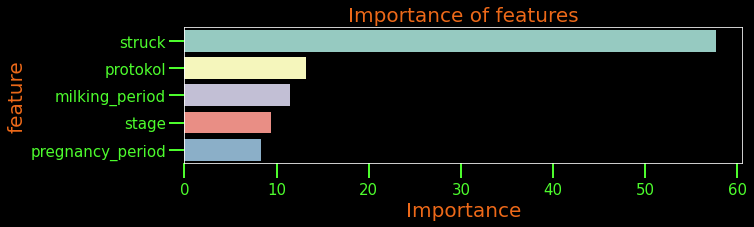

In [86]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (10, len(feature_importances) * 0.5))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
show_feature_importances(X_train.columns, model.feature_importances_)

In [88]:
from catboost import Pool
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values=explainer.shap_values(Pool(X_test, y_test, cat_features = cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

In [ ]:
pipe.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, pipe.predict(X_train)))

In [ ]:
print(classification_report(y_test, pipe.predict(X_test), digits=5))

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'models__estimator__n_estimators': [50, 100],
    'models__estimator__criterion': ['gini', 'entropy'],
    'models__estimator__max_depth': [10, 30, 50, 100],
    'models__estimator__min_samples_split': [2, 5, 10, 15],
    'models__estimator__min_samples_leaf': [2, 5]
}

search = RandomizedSearchCV(pipe, param_distributions=param_grid, n_jobs=-1, cv=5)
# search = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1, cv=5)
search.fit(X_train, y_train)

In [ ]:
print(classification_report(y_train, search.predict(X_train)))

In [ ]:
print(classification_report(y_test, search.predict(X_test)))